# Deep learning in genomics

This notebook is based on the [jupyter notebook](https://github.com/abidlabs/deep-learning-genomics-primer/blob/master/A_Primer_on_Deep_Learning_in_Genomics_Public.ipynb) from the publication ["A primer on deep learning in genomics"](https://www.nature.com/articles/s41588-018-0295-5) but uses the [fastai](https://www.fast.ai) library based on [PyTorch](https://pytorch.org).

# Notebook setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [4]:
# fastai version
__version__

'1.0.35.dev0'

# Data setup

## Load data from the web, generate dataframe, and save to disk

In [5]:
import requests

In [6]:
URL_seq = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/sequences.txt'

In [7]:
# get data from URL
seq_raw = requests.get(URL_seq).text.split('\n')
seq_raw = list(filter(None, seq_raw)) # Removes empty lists

In [8]:
# check length
len(seq_raw)

2000

In [9]:
# setup df from list
seq_df = pd.DataFrame(seq_raw, columns=['Sequences'])

In [10]:
# show head of dataframe
#seq_df.head()

In [11]:
URL_labels = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/labels.txt'

In [12]:
seq_labels = requests.get(URL_labels).text.split('\n')
seq_labels = list(filter(None, seq_labels)) # Removes empty entries

In [13]:
len(seq_labels)

2000

In [14]:
seq_label_series = pd.Series(seq_labels)

In [15]:
seq_df['Target'] = seq_label_series.astype('int')

In [16]:
seq_df.head()

,Sequences,Target
0,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...,0
1,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...,0
2,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...,0
3,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...,1
4,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...,1


In [67]:
seq_df.to_csv('seq_df.csv')

## Data frame setup

In [5]:
seq_df = pd.read_csv('seq_df.csv', index_col=0)

In [6]:
#seq_df.drop('Unnamed: 0', axis=1, inplace=True)

In [7]:
seq_df.head()

,Sequences,Target
0,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...,0
1,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...,0
2,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...,0
3,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...,1
4,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...,1


In [8]:
targA = seq_df['Target'].values; targA

array([0, 0, 0, 1, ..., 1, 0, 1, 1])

In [9]:
targB = np.logical_not(seq_df['Target'].values).astype(int); targB

array([1, 1, 1, 0, ..., 0, 1, 0, 0])

In [10]:
targ = [[a,b] for a, b in zip(targA, targB)]; targ[:4], '...', targ[-4:]#, len(targ)

([[0, 1], [0, 1], [0, 1], [1, 0]], '...', [[1, 0], [0, 1], [1, 0], [1, 0]])

### Preprocessing for MultiTarget (only needed for fastai training)

In [13]:
seq_df['MultiTarget'] = targ

In [14]:
def joinarray(x):
    y = ';'.join((str(x[0]),str(x[1])))
    return y

In [15]:
seq_df['MultiTarget'] = seq_df['MultiTarget'].apply(joinarray)

In [16]:
seq_df.head()

,Sequences,Target,MultiTarget
0,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...,0,0;1
1,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...,0,0;1
2,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...,0,0;1
3,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...,1,1;0
4,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...,1,1;0


## Dataset setup for training with basic PyTorch

### Setup sqeuence to array function

In [11]:
def seq2array(seq:str)->List:
    "Return `List` object with np.array created from sequence string `seq`."
    
    int_enc = LabelEncoder() # setup class instance to encode the four different bases to integer values (1D)
    one_hot_enc = OneHotEncoder(categories=[range(4)]) # setup one hot encoder to encode integer encoded classes (1D) to one hot encoded array (4D)
    
    enc = int_enc.fit_transform(list(seq)) # bases (ACGT) to int (0,1,2,3)
    enc = np.array(enc).reshape(-1,1) # reshape to get rank 2 array (from rank 1 array)
    enc = one_hot_enc.fit_transform(enc) # encoded integer encoded bases to sparse matrix (sparse matrix dtype)
    enc = enc.toarray().T # export sparse matrix to np array
    
    return enc

In [12]:
# test open sequence function
test_arr = seq2array('CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGACACC'); test_arr, test_arr.shape

(array([[0., 0., 0., 1., ..., 0., 1., 0., 0.],
        [1., 1., 0., 0., ..., 1., 0., 1., 1.],
        [0., 0., 1., 0., ..., 0., 0., 0., 0.],
        [0., 0., 0., 0., ..., 0., 0., 0., 0.]]), (4, 50))

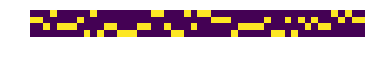

In [13]:
plt.imshow(test_arr)
plt.axis('off');

In [14]:
test_ten = tensor(test_arr).view(1,4,50).type(torch.float); test_ten

tensor([[[0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.],
         [1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
          0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1.],
         [0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
          1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
          1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0.,
          0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])

In [15]:
# run test data through network
#net(test_ten)

### Setup datasets

In [16]:
x = [tensor(seq2array(s)).view(1,4,50).type(torch.float) for s in seq_df['Sequences'].values]

In [17]:
x = torch.stack(x) # convert list to tensor

In [18]:
y = tensor(targ).type(torch.float)

In [19]:
len(x), len(y)

(2000, 2000)

In [20]:
# check data
i = 2
x[i], y[i]

(tensor([[[0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1.,
           1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
           1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
          [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
           0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1.,
           0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
          [1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.],
          [0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]]]),
 tensor([0., 1.]))

In [21]:
# split dataset
train_ds = TensorDataset(x[:1500],y[:1500])
valid_ds = TensorDataset(x[-500:],y[-500:])

In [22]:
# verify dataset length
len(train_ds), len(valid_ds)

(1500, 500)

## fastai data object

### Data encoding test (incorporated into "open_seq_image" function in the next section)

In [86]:
# setup class instance to encode the four different bases to integer values (1D)
int_enc = LabelEncoder()

In [87]:
# setup one hot encoder to encode integer encoded classes (1D) to one hot encoded array (4D)
one_hot_enc = OneHotEncoder(categories=[range(4)])

In [88]:
seq_enc = []

for s in seq:
    enc = int_enc.fit_transform(list(s)) # bases (ACGT) to int (0,1,2,3)
    enc = np.array(enc).reshape(-1,1) # reshape to get rank 2 array (from rank 1 array)
    enc = one_hot_enc.fit_transform(enc) # encoded integer encoded bases to sparse matrix (sparse matrix dtype)
    seq_enc.append(enc.toarray()) # export sparse matrix to np array

In [89]:
len(seq_enc)

2000

In [462]:
seq_enc[0].T, seq_enc[0].T.shape

(array([[0., 0., 0., 1., ..., 0., 1., 0., 0.],
        [1., 1., 0., 0., ..., 1., 0., 1., 1.],
        [0., 0., 1., 0., ..., 0., 0., 0., 0.],
        [0., 0., 0., 0., ..., 0., 0., 0., 0.]]), (4, 50))

In [311]:
PIL.Image.fromarray(seq_enc[0].T.astype('uint8')*255).convert('P')

### Setup custom fastai data object

In [11]:
# open sequence image function
def open_seq_image(seq:str, cls:type=Image)->Image:
    "Return `Image` object created from sequence string `seq`."
    
    int_enc = LabelEncoder() # setup class instance to encode the four different bases to integer values (1D)
    one_hot_enc = OneHotEncoder(categories=[range(4)]) # setup one hot encoder to encode integer encoded classes (1D) to one hot encoded array (4D)
    
    enc = int_enc.fit_transform(list(seq)) # bases (ACGT) to int (0,1,2,3)
    enc = np.array(enc).reshape(-1,1) # reshape to get rank 2 array (from rank 1 array)
    enc = one_hot_enc.fit_transform(enc) # encoded integer encoded bases to sparse matrix (sparse matrix dtype)
    enc = enc.toarray().T # export sparse matrix to np array
    #print('enc', enc, enc.shape)
    
    # https://stackoverflow.com/questions/22902040/convert-black-and-white-array-into-an-image-in-python
    x = PIL.Image.fromarray(enc.astype('uint8')).convert('P')
    x = pil2tensor(x,np.float32)
    #x = x.view(4,-1) # remove first dimension
    #x = x.expand(3, 4, 50) # expand to 3 channel image
    #print('x', x, x.shape)
    return cls(x)

In [12]:
# test open sequence image function
open_seq_image('CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGACACC')

In [13]:
class SeqItemList(ImageItemList):
    _bunch,_square_show = ImageDataBunch,True
    def __post_init__(self):
        super().__post_init__()
        self.sizes={}
    
    def open(self, seq): return open_seq_image(seq)
    
    def get(self, i):
        seq = self.items[i][0]
        res = self.open(seq)
        return res
    
    @classmethod
    def import_from_df(cls, df:DataFrame, cols:IntsOrStrs=0, **kwargs)->'ItemList':
        "Get the sequences in `col` of `df` and will had `path/folder` in front of them, `suffix` at the end."
        return cls(items=df[cols].values)

In [36]:
bs = 64

In [81]:
data = (SeqItemList.import_from_df(seq_df, ['Sequences'])
        .random_split_by_pct(valid_pct=0.25)
        #.split_by_idxs(range(1500), range(1500,2000))
        .label_from_list(seq_df['Target'].values) # --> Two categories! AND WRONG LOSS FUNCTION!?
        #.label_from_list(targ) # --> MultiCategory
        #.label_from_list(seq_df['MultiTarget'], sep=';')
        #.label_from_list(seq_df['Target'].values, sep=';')
        .databunch(bs=bs))

### Verify data object

#### Check data object

In [82]:
data

ImageDataBunch;

Train: LabelList
y: CategoryList (2000 items)
[Category 0, Category 0, Category 0, Category 1, Category 1]...
Path: .
x: SeqItemList (1500 items)
[Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50)]...
Path: .;

Valid: LabelList
y: CategoryList (2000 items)
[Category 0, Category 0, Category 0, Category 1, Category 1]...
Path: .
x: SeqItemList (500 items)
[Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50)]...
Path: .;

Test: None

In [83]:
# check classes
data.c, data.classes

(2, [0, 1])

In [84]:
data.train_dl.batch_size

64

In [85]:
# show array data of one batch
#next(iter(data.train_dl))

#### Check data points

In [86]:
i = 2
data.x[i]

In [87]:
data.y[i]

Category 0

In [88]:
i = 3
data.x[i]

In [89]:
data.y[i]

Category 1

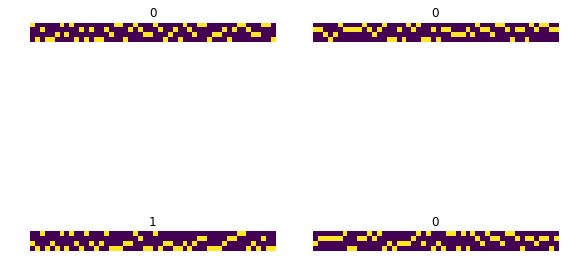

In [91]:
data.show_batch(rows=2)

# Model setup

## Basic model for PyTorch training

In [23]:
def Flatten(): return Lambda(lambda x: x.view((x.size(0), -1)))

In [24]:
def ResizeInput(): return Lambda(lambda x: x.view((-1,)+x.size()[-2:]))

In [25]:
#def ResizeOutput(): return Lambda(lambda x: x.view(-1))

In [26]:
drop_p = 0.2

In [27]:
# inplace=True seems to generate problems?

In [28]:
net_basic = nn.Sequential(ResizeInput(),
                    nn.Conv1d(in_channels=4, out_channels=32, kernel_size=12),
                    nn.MaxPool1d(kernel_size=4),
                    Flatten(),
                    nn.Dropout(drop_p),
                    nn.Linear(in_features=288, out_features=16),
                    nn.ReLU(),
                    nn.Dropout(drop_p),
                    nn.Linear(in_features=16, out_features=2),
                    #nn.Dropout(drop_p), # not at the end?
                    #Debugger()
                   )

In [29]:
# check network architecture
net_basic

Sequential(
  (0): Lambda()
  (1): Conv1d(4, 32, kernel_size=(12,), stride=(1,))
  (2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (3): Lambda()
  (4): Dropout(p=0.2)
  (5): Linear(in_features=288, out_features=16, bias=True)
  (6): ReLU()
  (7): Dropout(p=0.2)
  (8): Linear(in_features=16, out_features=2, bias=True)
)

In [30]:
# initialize weights with kaiming normal initialization
apply_init(net_basic, nn.init.kaiming_normal_)

## Basic model for fastai training

In [ ]:
def Flatten(): return Lambda(lambda x: x.view((x.size(0), -1)))

In [ ]:
def ResizeInput(): return Lambda(lambda x: x.view((-1,)+x.size()[-2:]))

In [184]:
drop_p = 0.4

In [194]:
net_basic_fastai = nn.Sequential(ResizeInput(),
                    nn.Conv1d(in_channels=4, out_channels=32, kernel_size=12),
                    nn.MaxPool1d(kernel_size=4),
                    Flatten(),
                    nn.Dropout(drop_p),
                    nn.Linear(in_features=288, out_features=16),
                    nn.ReLU(),
                    nn.Dropout(drop_p),
                    nn.Linear(in_features=16, out_features=2),
                    #nn.Dropout(drop_p), # not at the end?
                    #Debugger()
                   )

In [195]:
net_basic_fastai

Sequential(
  (0): Lambda()
  (1): Conv1d(4, 32, kernel_size=(12,), stride=(1,))
  (2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (3): Lambda()
  (4): Dropout(p=0.4)
  (5): Linear(in_features=288, out_features=16, bias=True)
  (6): ReLU()
  (7): Dropout(p=0.4)
  (8): Linear(in_features=16, out_features=2, bias=True)
)

In [196]:
# initialize weights with kaiming normal initialization
apply_init(net_basic_fastai, nn.init.kaiming_normal_)

## Custom fastai ResNet model

In [230]:
learn_dummy = create_cnn(data, models.resnet18)

In [231]:
learn_dummy.loss_func.func

CrossEntropyLoss()

In [233]:
#learn_resnet.model[0]

In [234]:
learn_dummy.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Lambda()
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25)
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): ReLU(inplace)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5)
  (8): Linear(in_features=512, out_features=2, bias=True)
)

### Setup custom input stage

In [235]:
# define function to create 3 channel image from 1 channel image.
def ExpandInput(): return Lambda(lambda x: x.expand(-1, 3, 4, 50))

In [236]:
EI = ExpandInput()

#### Test ExpandInput layer

In [237]:
tt = torch.rand((64,1,4,50)); tt.shape

torch.Size([64, 1, 4, 50])

In [238]:
tt.expand(-1, 3, 4, 50).shape

torch.Size([64, 3, 4, 50])

In [239]:
Image(EI(tt)[0])

### Insert custom input stage

In [240]:
net_custom_resnet = nn.Sequential(ExpandInput(), learn_dummy.model) # insert ExpandInput layer at the beginning of the network

In [242]:
# run dummy data through custom input stage to test it
net_custom_resnet[0](tt).shape

torch.Size([64, 3, 4, 50])

# Model training

## Train basic model with PyTorch

In [31]:
bs = 64

In [32]:
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs*2, shuffle=False)

In [35]:
opt = optim.SGD(net_basic.parameters(), lr=1e-3, momentum=0.9)

In [36]:
# Based on https://github.com/fastai/fastai_docs/blob/master/dev_nb/mnist_sample.py

def simple_loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

def simple_fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl: simple_loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses,nums = zip(*[simple_loss_batch(model, loss_func, xb, yb)
                                for xb,yb in valid_dl])
            
            # Accuracy metric:
            thr = 0.5
            comp = [np.array(torch.sigmoid(model(xb)).detach().numpy()>thr).astype(int)==yb.detach().numpy().astype(int)
                          for xb,yb in valid_dl]
            acc = np.concatenate(comp).mean()
            
            # use fastai accuracy() func?
            #output = 
            
        val_loss = np.sum(np.multiply(losses,nums)) / np.sum(nums)

        #if epoch % 10 == 0:
        print(epoch, val_loss, acc)

In [59]:
simple_fit(50, net_basic, F.binary_cross_entropy_with_logits, opt, train_dl, valid_dl)

0 0.19586651754379272 0.932
1 0.19660570287704468 0.929
2 0.19295910632610322 0.93
3 0.19240641164779662 0.931
4 0.18970949673652648 0.935
5 0.18764417684078216 0.933
6 0.18706315910816193 0.935
7 0.18746764409542083 0.932
8 0.1857880744934082 0.937
9 0.18319485437870026 0.94
10 0.1809044394493103 0.938
11 0.18096670472621917 0.936
12 0.1783504251241684 0.941
13 0.17732288146018982 0.94
14 0.17641971135139464 0.939
15 0.1762392818927765 0.939
16 0.17381491482257844 0.941
17 0.17343695032596587 0.942
18 0.17324936163425445 0.939
19 0.17034213876724244 0.944
20 0.1676717177629471 0.946
21 0.1668849548101425 0.945
22 0.16691377973556518 0.942
23 0.16495974087715148 0.943
24 0.1630959119796753 0.949
25 0.16274057507514952 0.947
26 0.16158011531829833 0.95
27 0.16742867410182952 0.941
28 0.15947548139095308 0.95
29 0.1593805228471756 0.947
30 0.1568965196609497 0.951
31 0.15801458489894868 0.947
32 0.15776014626026152 0.949
33 0.15457441079616546 0.951
34 0.15362511539459228 0.952
35 0.1521

In [60]:
valid_dl = DataLoader(valid_ds, batch_size=bs*2, shuffle=False)

In [61]:
xbatch, ybatch = next(iter(valid_dl)); xbatch.shape, ybatch.shape

(torch.Size([128, 1, 4, 50]), torch.Size([128, 2]))

In [62]:
ybatch[:10].detach().numpy().astype(int)

array([[0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0]])

In [63]:
np.array(torch.sigmoid(net_basic(xbatch[:10])).detach().numpy()>0.5).astype(int)

array([[0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0]])

In [64]:
#np.array(torch.sigmoid(net(xbatch)).detach().numpy()>0.5).astype(int)==ybatch.detach().numpy().astype(int)

In [65]:
np.array(np.array(torch.sigmoid(net_basic(xbatch)).detach().numpy()>0.5).astype(int)==ybatch.detach().numpy().astype(int)).mean()

0.9453125

In [66]:
np.concatenate(np.array(torch.sigmoid(net_basic(xbatch)).detach().numpy()>0.5).astype(int)==ybatch.detach().numpy().astype(int)).mean()

0.9453125

In [67]:
np.concatenate([np.array(torch.sigmoid(net_basic(xb)).detach().numpy()>0.5).astype(int)==yb.detach().numpy().astype(int) for xb,yb in valid_dl]).mean()


0.957

In [68]:
[np.concatenate(np.array(torch.sigmoid(net_basic(xb)).detach().numpy()>0.5).astype(int)==yb.detach().numpy().astype(int)).mean() for xb,yb in valid_dl]


[0.9453125, 0.94921875, 0.98046875, 0.9525862068965517]

In [55]:
data.train_ds[0][1], data.train_ds[3][1]

NameError: name 'data' is not defined

In [56]:
net_basic(data.train_ds[0][0].data), net_basic(data.train_ds[3][0].data)

NameError: name 'data' is not defined

In [169]:
torch.sigmoid(net_basic(data.train_ds[0][0].data)).detach().numpy()>0.5

array([[False,  True]])

In [170]:
torch.sigmoid(net_basic(data.train_ds[3][0].data)).detach().numpy()>0.5

array([[ True, False]])

## Tensorboard logger

In [35]:
import tensorflow as tf

# From https://gist.github.com/gyglim/1f8dfb1b5c82627ae3efcfbbadb9f514
"""Simple example on how to log scalars and images to tensorboard without tensor ops.
License: Copyleft
"""
#__author__ = "Michael Gygli"

#import tensorflow as tf
#from StringIO import StringIO
#import matplotlib.pyplot as plt
#import numpy as np

class Logger(object):
    """Logging in tensorboard without tensorflow ops."""

    def __init__(self, log_dir):
        """Creates a summary writer logging to log_dir."""
        self.writer = tf.summary.FileWriter(log_dir)

    def log_scalar(self, tag, value, step):
        """Log a scalar variable.
        Parameter
        ----------
        tag : basestring
            Name of the scalar
        value
        step : int
            training iteration
        """
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag,
                                                     simple_value=value)])
        self.writer.add_summary(summary, step)

    def log_images(self, tag, images, step):
        """Logs a list of images."""

        im_summaries = []
        for nr, img in enumerate(images):
            # Write the image to a string
            s = StringIO()
            plt.imsave(s, img, format='png')

            # Create an Image object
            img_sum = tf.Summary.Image(encoded_image_string=s.getvalue(),
                                       height=img.shape[0],
                                       width=img.shape[1])
            # Create a Summary value
            im_summaries.append(tf.Summary.Value(tag='%s/%d' % (tag, nr),
                                                 image=img_sum))

        # Create and write Summary
        summary = tf.Summary(value=im_summaries)
        self.writer.add_summary(summary, step)
        

    def log_histogram(self, tag, values, step, bins=1000):
        """Logs the histogram of a list/vector of values."""
        # Convert to a numpy array
        values = np.array(values)
        
        # Create histogram using numpy        
        counts, bin_edges = np.histogram(values, bins=bins)

        # Fill fields of histogram proto
        hist = tf.HistogramProto()
        hist.min = float(np.min(values))
        hist.max = float(np.max(values))
        hist.num = int(np.prod(values.shape))
        hist.sum = float(np.sum(values))
        hist.sum_squares = float(np.sum(values**2))

        # Requires equal number as bins, where the first goes from -DBL_MAX to bin_edges[1]
        # See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/core/framework/summary.proto#L30
        # Thus, we drop the start of the first bin
        bin_edges = bin_edges[1:]

        # Add bin edges and counts
        for edge in bin_edges:
            hist.bucket_limit.append(edge)
        for c in counts:
            hist.bucket.append(c)

        # Create and write Summary
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, histo=hist)])
        self.writer.add_summary(summary, step)
        self.writer.flush()
        
"A `Callback` that saves tracked metrics into a log file for Tensorboard."
# Based on https://gist.github.com/gyglim/1f8dfb1b5c82627ae3efcfbbadb9f514
# and devforfu: https://nbviewer.jupyter.org/gist/devforfu/ea0b3fcfe194dad323c3762492b05cae
# Contribution from MicPie

#from ..torch_core import *
#from ..basic_data import DataBunch
#from ..callback import *
#from ..basic_train import Learner, LearnerCallback
#import tensorflow as tf

__all__ = ['TBLogger']

@dataclass
class TBLogger(LearnerCallback):
    "A `LearnerCallback` that saves history of metrics while training `learn` into log files for Tensorboard."
    
    log_dir:str = 'logs'
    log_name:str = 'data'
    log_scalar:bool = True # log scalar values for Tensorboard scalar summary
    log_hist:bool = True # log values and gradients of the parameters for Tensorboard histogram summary
    log_img:bool = False # log values for Tensorboard image summary

    def __post_init__(self): 
        super().__post_init__()
    #def __init__(self):
    #    super().__init__()
        self.path = self.learn.path
        (self.path/self.log_dir).mkdir(parents=True, exist_ok=True) # setup logs directory
        self.Log = Logger(str(self.path/self.log_dir/self.log_name))
        self.epoch = 0
        self.batch = 0
        self.log_grads = {}
    
    def on_backward_end(self, **kwargs:Any):
        self.batch = self.batch+1
        #print('\nBatch: ',self.batch)
        
        if self.log_hist:
            for tag, value in learn.model.named_parameters():
                tag_grad = tag.replace('.', '/')+'/grad'
                
                if tag_grad in self.log_grads:
                    #self.log_grads[tag_grad] += value.grad.data.cpu().detach().numpy()
                    self.log_grads[tag_grad] = self.log_grads[tag_grad] + value.grad.data.cpu().detach().numpy() # gradients are summed up from every batch
                    #print('if')
                else:
                    self.log_grads[tag_grad] = value.grad.data.cpu().detach().numpy()
                    #print('else')
                
                #print(tag_grad, self.log_grads[tag_grad].sum())
        return self.log_grads
    
    #def on_step_end(self, **kwards:Any):
        #print('Step end: ', self.log_grads)

    def on_epoch_end(self, epoch:int, smooth_loss:Tensor, last_metrics:MetricsList, **kwargs:Any) -> bool:
        last_metrics = ifnone(last_metrics, [])
        tr_info = {name: stat for name, stat in zip(self.learn.recorder.names, [epoch, smooth_loss] + last_metrics)}
        self.epoch = tr_info['epoch']
        self.batch = 0 # reset batch count
        #print('\nEpoch: ',self.epoch)
        
        if self.log_scalar:
            for tag, value in tr_info.items():
                if tag == 'epoch': continue
                self.Log.log_scalar(tag, value, self.epoch+1)
                
        if self.log_hist:
            for tag, value in learn.model.named_parameters():
                
                tag = tag.replace('.', '/')
                self.Log.log_histogram(tag, value.data.cpu().numpy(), self.epoch+1)
                
                tag_grad = tag.replace('.', '/')+'/grad'
                self.Log.log_histogram(tag_grad, self.log_grads[tag_grad], self.epoch+1)
                #print(tag_grad, self.log_grads[tag_grad].sum())
                
        #if self.log_img:
        #    for tag, value in learn.model.named_parameters():
        #        
        #        tag = tag.replace('.', '/')
        #        self.Log.log_images(tag, value.data.cpu().numpy(), self.epoch+1)

## Train basic model with fastai

In [208]:
#learn = Learner(data, net, loss_func=nn.functional.cross_entropy, metrics=accuracy)#, callback_fns=[TBLogger])

In [100]:
#def accuracy_float(input:Tensor, targs:LongTensor)->Rank0Tensor:
#    "Compute accuracy with `targs` when `input` is bs * n_classes."
#    n = targs.shape[0]
#    input = input.argmax(dim=-1).view(n,-1)
#    targs = targs.type(torch.long) # convert to torch.long = int64 --> difference to accuracy metric!
#    targs = targs.view(n,-1)
#    return (input==targs).float().mean()

In [197]:
learn = Learner(data, net_basic_fastai, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)#_float)#, callback_fns=[TBLogger])

In [198]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Lambda               [64, 4, 50]          0          False     
______________________________________________________________________
Conv1d               [64, 32, 39]         1568       True      
______________________________________________________________________
MaxPool1d            [64, 32, 9]          0          False     
______________________________________________________________________
Lambda               [64, 288]            0          False     
______________________________________________________________________
Dropout              [64, 288]            0          False     
______________________________________________________________________
Linear               [64, 16]             4624       True      
______________________________________________________________________
ReLU                 [64, 16]             0          False     
______________________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


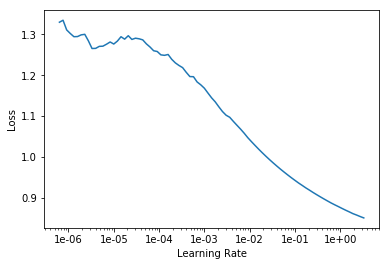

In [190]:
learn.lr_find()
learn.recorder.plot()

In [199]:
learn.fit(50, lr=1e-3)

epoch,train_loss,valid_loss,accuracy
1,0.808901,0.696700,0.486000
2,0.745595,0.691503,0.526000
3,0.723365,0.692632,0.526000
4,0.711237,0.692701,0.524000
5,0.704650,0.692727,0.524000
6,0.699970,0.692452,0.524000
7,0.697248,0.693120,0.520000
8,0.696850,0.692632,0.524000
9,0.695233,0.692109,0.538000
10,0.695056,0.692462,0.524000


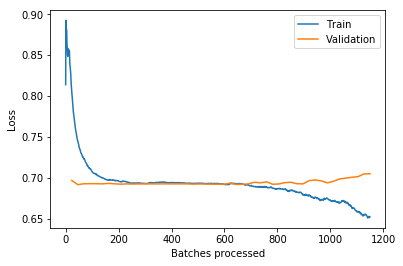

In [200]:
learn.recorder.plot_losses()

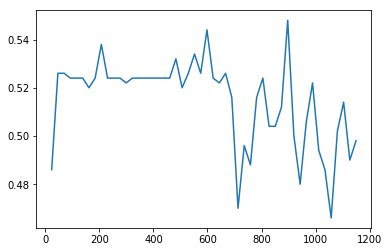

In [201]:
learn.recorder.plot_metrics()

In [191]:
learn.fit_one_cycle(50, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy
1,1.168377,0.913809,0.474000
2,1.095537,0.783380,0.478000
3,1.007020,0.709974,0.520000
4,0.924864,0.696400,0.526000
5,0.861490,0.690772,0.520000
6,0.810732,0.688738,0.522000
7,0.776933,0.690691,0.518000
8,0.751327,0.690573,0.516000
9,0.732311,0.691513,0.506000
10,0.721617,0.691588,0.518000


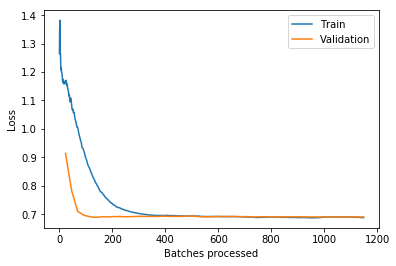

In [192]:
learn.recorder.plot_losses()

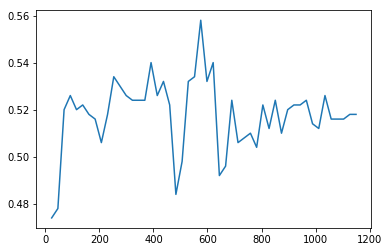

In [193]:
learn.recorder.plot_metrics()

In [202]:
learn.get_preds(DatasetType.Train)

[tensor([[0.6870, 0.3130],
         [0.6266, 0.3734],
         [0.7430, 0.2570],
         ...,
         [0.5513, 0.4487],
         [0.5263, 0.4737],
         [0.5589, 0.4411]]), tensor([0, 0, 0,  ..., 0, 1, 1])]

In [203]:
data.train_ds[0][1], data.train_ds[3][1]

(Category 0, Category 1)

In [204]:
#net(data.train_ds[0][0].data), net(data.train_ds[3][0].data)

In [205]:
learn.model(data.train_ds[0][0].data), net(data.train_ds[3][0].data)

(tensor([[ 0.0890, -0.0504]], grad_fn=<ThAddmmBackward>),
 tensor([[ 0.1637, -1.3496]], grad_fn=<ThAddmmBackward>))

In [206]:
torch.sigmoid(learn.model(data.train_ds[0][0].data)).detach().numpy()#>0.5

array([[0.52224 , 0.487406]], dtype=float32)

In [207]:
torch.sigmoid(learn.model(data.train_ds[3][0].data)).detach().numpy()#>0.5

array([[0.510929, 0.462015]], dtype=float32)

In [208]:
i = 7

In [209]:
data.train_ds[i][1]

Category 0

In [210]:
learn.model(data.train_ds[i][0].data)

tensor([[ 0.1135, -0.3763]], grad_fn=<ThAddmmBackward>)

In [211]:
torch.sigmoid(learn.model(data.train_ds[i][0].data)).detach().numpy()#>0.5

array([[0.528338, 0.407023]], dtype=float32)

In [212]:
preds, targs = learn.get_preds()

In [213]:
#targs.view(-1,1)

In [214]:
#preds

In [215]:
i = 0
preds[i], targs[i]

(tensor([0.4841, 0.5159]), tensor(0))

In [216]:
data.train_ds[0], data.train_ds[3]

((Image (1, 4, 50), Category 0), (Image (1, 4, 50), Category 1))

In [217]:
learn.predict(data.train_ds[0][0]), learn.predict(data.train_ds[3][0])

((Category 0, tensor(0), tensor([0.5348, 0.4652])),
 (Category 0, tensor(0), tensor([0.5488, 0.4512])))

In [125]:
#learn.save('v6')

In [126]:
#learn.load('v6')

In [218]:
interpret = ClassificationInterpretation.from_learner(learn)

In [219]:
interpret.confusion_matrix()

array([[164,  98],
       [153,  85]])

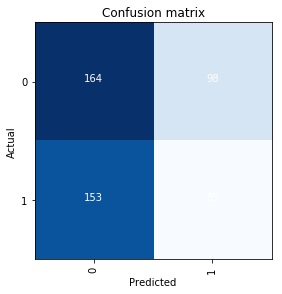

In [220]:
interpret.plot_confusion_matrix()

## Train custom fastai ResNet with fastai 

In [243]:
learn_resnet = Learner(data, net_custom_resnet, metrics=accuracy)

In [244]:
#[p.shape for p in net_custom_resnet.parameters()]

In [245]:
learn_resnet.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy
1,0.557348,0.841440,0.508000
2,0.583182,0.879271,0.494000
3,0.558499,0.848773,0.506000
4,0.515747,0.914593,0.512000
5,0.476116,0.917134,0.504000


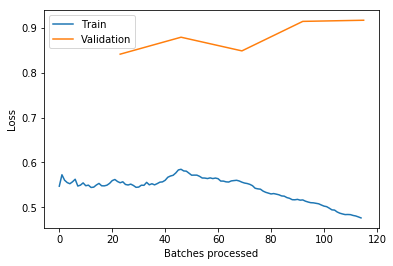

In [246]:
learn_resnet.recorder.plot_losses()

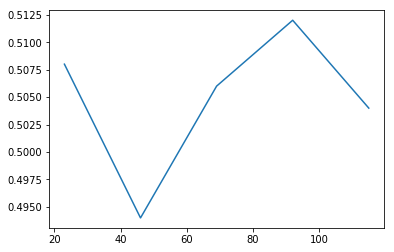

In [248]:
learn_resnet.recorder.plot_metrics()

In [138]:
#test_learn.get_preds() # is not working!